# A note: Run this notebook in the arcgis software as we'll need the suitable enviornment (ArcGISPro3) or in VS-code but make sure to set up the arcgis enviornment.   

# Imports
## Apart from imports, please do download the arcgis deep learning dependencies from their github. It contains all the computer vision and deep learning dependencies (mostly torch and tensorflow) in versions that are compatible with each other. You can install it from the readme which is available there too and also, uploaded with the dataset.  

In [1]:
import torch

In [23]:
torch.cuda.empty_cache()
print("done")

done


In [2]:
import arcgis.learn

"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?


In [3]:
import arcgis

In [ ]:
import os, zipfile
from pathlib import Path
from arcgis.gis import GIS

In [23]:
cd

C:\Users\pand8760


##### import arcpy  
from arcpy.ia import *

In [4]:
from arcgis.learn import prepare_data, MultiTaskRoadExtractor, UnetClassifier,PSPNetClassifier

# Pre-processing 

In [ ]:
# Converting geojson labels to shapefiles
import arcpy
import os

# Set the input and output folders
input_folder = r"E:\AOI_4_Paris\geojson_roads"
output_folder = r'E:\Paris_features'

# Ensure the output folder exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Loop through all files in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".geojson"):
        input_json = os.path.join(input_folder, filename)
        output_fc = os.path.join(output_folder, filename.replace(".geojson", ".shp"))
        
        # Convert JSON to feature class
        arcpy.JSONToFeatures_conversion(input_json, output_fc, geometry_type = 'POLYLINE')
        
        #print(f"Converted {filename} to feature class")

print("Conversion completed for all GeoJSON files in the folder.")

In [ ]:
"""Stretching the pics from 16bit to 8bit for faster processing"""
import arcpy
import os

# Set the input and output folders
input_folder = r"E:\AOI_4_Paris\PS-RGB"
output_folder = r'E:\paris_stretched'

# Ensure the output folder exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Loop through all files in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".tif"):
        input_raster = os.path.join(input_folder, filename)
        output_raster = os.path.join(output_folder, filename)
        
        # Apply stretch function
        stretched_raster = arcpy.ia.Stretch(input_raster)
        stretched_raster.save(output_raster)
        
        print(f"Applied stretch function to {filename}")

print("Stretch function applied to all raster files in the folder.")

import arcpy
import os

"""To repair the geometry in shapefiles if unrocessable but not needed in 
most cases. So comment out the code while stretching the pics."""
input_folder = r"E:\Paris_features"

# Loop through all files in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".shp"):
        input_shapefile = os.path.join(input_folder, filename)
        
        # Repair geometry
        arcpy.RepairGeometry_management(input_shapefile)
        
        print(f"Repaired geometry for: {filename}")

print("Geometry repair completed for all shapefiles in the folder.")

In [ ]:
# For converting the data into a suitable format for ArcGIS
input_raster = r"E:\shanghai_stretched\SN3_roads_train_AOI_4_Paris_PS-RGB_img2.tif"
input_features = r'E:\features_to_use\SN3_roads_train_AOI_4_Paris_geojson_roads_img2.shp'
output_folder = r'E:\Export'
arcpy.ia.ExportTrainingDataForDeepLearning(
    in_raster=input_raster,
    in_class_data=input_features,
    out_folder=output_folder,
    image_chip_format="TIFF",
    metadata_format = 'Classified_Tiles',
    processing_mode = 'PROCESS_AS_MOSAICKED_IMAGE',
    tile_size_x=256,
    tile_size_y=256,
    stride_x=64,
    stride_y=64,
    class_value_field = "ClassValue", #Make sure to define the class values in images before running the code OTHERWISE IT WILL GENERATE BLANK OUTPUTS 
    buffer_radius = 1 # Specify the class field here
)

In [4]:
import os, zipfile
from pathlib import Path
from arcgis.gis import GIS

In [28]:
gis = GIS(username="pand8760", password="Vadapav@1033")

<Item title:"automatic_road_extraction_using_deep_learning" type:Image Collection owner:api_data_owner>
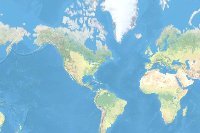

In [6]:
#training_data = gis.content.get('b7bbf2f5f4184960890afeabbdb51a32')
#training_data
#Download using the link below and use, do not use the download function from filepath.

In [7]:
#filepath = r"c:\Users\pand8760\Downloads\automatic_road_extraction_using_deep_learning.zip"

In [8]:
#with zipfile.ZipFile(filepath, 'r') as zip_ref:
    #zip_ref.extractall(Path(filepath).parent)

In [5]:
#output_path = Path(os.path.join(os.path.splitext(filepath)[0]))
#output path to prepare the data from
output_path = r"D:\automatic_road_extraction_using_deep_learning"

In [6]:
#the prepared data overlaps the pictures and labels for the models
data = prepare_data(output_path, chip_size=512, batch_size=4)

In [19]:
data.classes
"""Note, the 'NoData' and 2 here mean that NoData is nullifying everything as
background and 2 means there's a road on there. 2 here is the "ClassValue" we 
talked about while exporting the data; can be any value you want but, should be numeric
as ML training is done on numeric values."""

['NoData', '2']

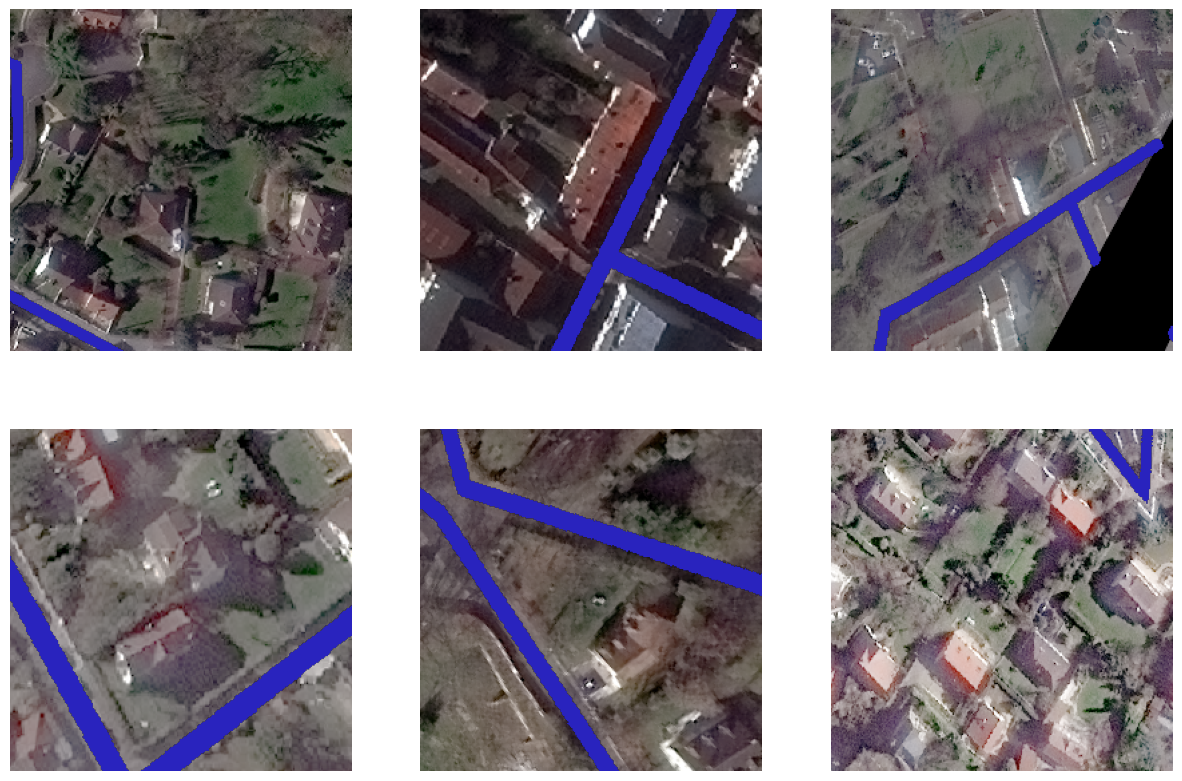

In [9]:
data.show_batch(alpha=1)

# Model Training

In [26]:
model = MultiTaskRoadExtractor(data, mtl_model="linknet")

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\LENOVO/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:17<00:00, 5.12MB/s]﻿


In [20]:
?MultiTaskRoadExtractor

Init signature:
MultiTaskRoadExtractor(
    data,
    backbone=None,
    pretrained_path=None,
    *args,
    **kwargs,
)
Docstring:     
Creates a Multi-Task Learning model for binary segmentation of roads. Supports RGB
and Multispectral Imagery.
Implementation based on https://doi.org/10.1109/CVPR.2019.01063 .

=====================   =====================================================
**Parameter**            **Description**
---------------------   -----------------------------------------------------
data                    Required fastai Databunch. Returned data object from
                        :meth:`~arcgis.learn.prepare_data`  function.
---------------------   -----------------------------------------------------
backbone                Optional String. Backbone convolutional neural network
                        model used for feature extraction. If hourglass is chosen as
                        the mtl_model (Architecture), then this parameter is
                      

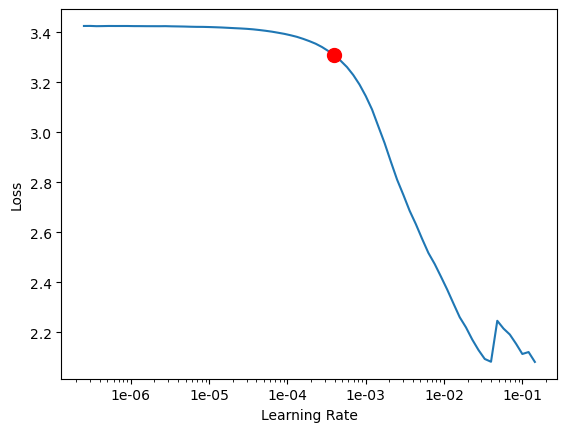

0.0003981071705534973

In [27]:
model.lr_find() #Don't need to do this as the optimal learning rate is found on it's own  

In [28]:
model.fit(11, lr=0.0003981071705534973 , early_stopping=True)

epoch     train_loss  valid_loss  accuracy  miou      dice      time    
0         0.235332    0.221688    0.965197  0.769080  0.691908  2:27:45   
1         0.134007    0.139259    0.984130  0.874680  0.834093  2:27:46   
2         0.093491    0.129770    0.981320  0.853482  0.798347  2:19:45   
3         0.063004    0.062410    0.993165  0.940417  0.915681  2:20:45   
4         0.046107    0.053314    0.994404  0.951611  0.931593  2:19:28   
5         0.035277    0.038558    0.996656  0.970122  0.956483  2:18:20   
6         0.027796    0.030974    0.997327  0.976152  0.963963  2:24:02   
7         0.022220    0.025874    0.998126  0.983065  0.973594  2:26:27   
8         0.018550    0.022294    0.998563  0.986977  0.979511  2:27:23   
9         0.015887    0.021035    0.998840  0.989422  0.982433  2:28:18   
10        0.014933    0.020610    0.998899  0.989974  0.983212  2:34:12   


In [29]:
model.save("E:\large\models\linknet")

Computing model metrics...


WindowsPath('E:/large/models/linknet')

In [13]:
data.classes

['NoData', 1]

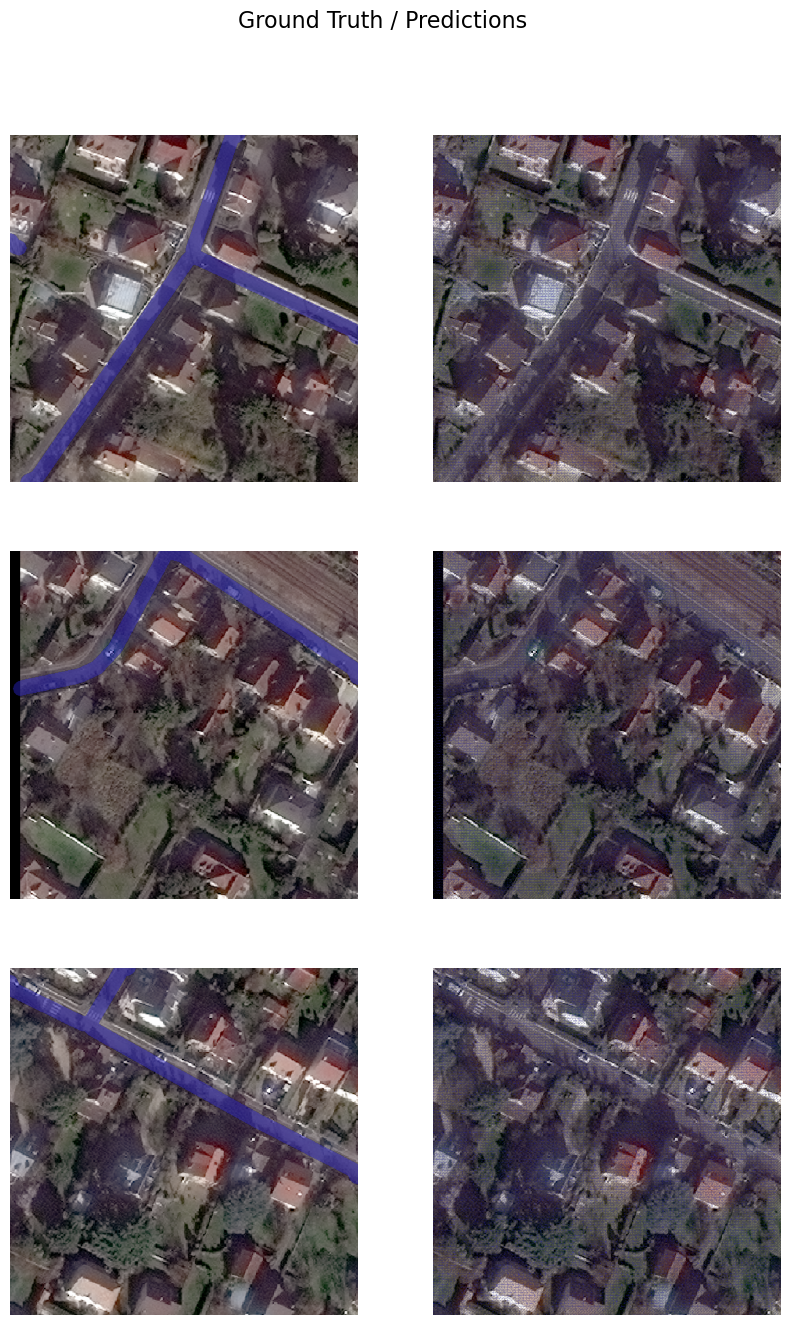

In [11]:
model.show_results(rows=3)

In [8]:
model_eff = UnetClassifier(data, backbone="timm:tf_mobilenetv3_small_100")

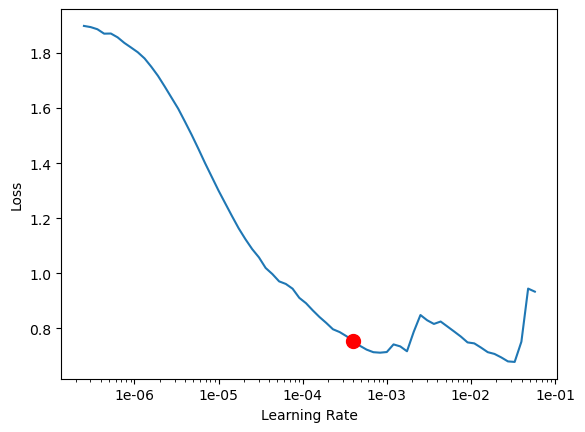

0.0003981071705534973

In [9]:
model_eff.lr_find()

In [1]:
model_eff.fit(11, lr=0.0003981071705534973 , early_stopping=True)
"""I have ran the same code on another notebook on a device with GPU as Unet took around 
4 hours 30 minutes for 1 epoch on my device which doesn't have a GPU.

As a result, I have uploaded the model into the dataset as mobilenet_v3 
(due to it being the backbone)"""

<class 'NameError'>: name 'model_eff' is not defined

In [2]:
model_eff.save("model_resnet34")

<class 'NameError'>: name 'model_eff' is not defined

In [16]:
?backbone

Object `backbone` not found.


In [10]:
?PSPNetClassifier

Init signature:
PSPNetClassifier(
    data,
    backbone=None,
    use_unet=True,
    pyramid_sizes=[1, 2, 3, 6],
    pretrained_path=None,
    unet_aux_loss=False,
    pointrend=False,
    *args,
    **kwargs,
)
Docstring:     
Model architecture from https://arxiv.org/abs/1612.01105.
Creates a PSPNet Image Segmentation/ Pixel Classification model.

=====================   ===========================================
**Parameter**            **Description**
---------------------   -------------------------------------------
data                    Required fastai Databunch. Returned data object from
                        :meth:`~arcgis.learn.prepare_data` function.
---------------------   -------------------------------------------
backbone                Optional string. Backbone convolutional neural network
                        model used for feature extraction, which
---Return to continue, q to quit---                                                            is `resnet50` by 

In [8]:
psp_resnet = PSPNetClassifier(data, backbone="resnet50",pointrend="True")

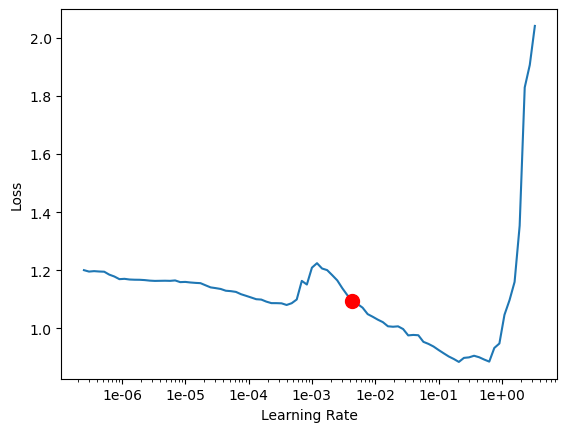

0.004365158322401656

In [8]:
psp_resnet.lr_find()

In [9]:
psp_resnet.fit(11, lr=0.004365158322401656 , early_stopping=True)

epoch     train_loss  valid_loss  accuracy  dice      time    
0         0.182219    0.117342    0.961321  0.293780  2:31:58   
1         0.172353    0.098809    0.958114  0.112879  1:45:08   
2         0.167277    0.094247    0.958711  0.587855  1:44:03   
3         0.157277    0.102044    0.962806  0.285441  1:43:42   
4         0.152263    0.081170    0.968436  0.595589  1:46:10   
5         0.144570    0.081070    0.965439  0.615878  1:43:26   
6         0.140537    0.070430    0.971197  0.548396  1:48:59   
7         0.136494    0.069624    0.971674  0.641297  1:47:11   
8         0.130701    0.067135    0.972060  0.598521  1:48:05   
9         0.140124    0.066541    0.972597  0.617753  1:49:54   
10        0.122820    0.066258    0.972723  0.609194  1:50:00   


In [10]:
psp_resnet.save("E:\large\models\pspnet")

Computing model metrics...


WindowsPath('E:/large/models/pspnet')

# Model testing.

In [ ]:
# Did this testing on about 4000 256x256 images
out_raster = ClassifyPixelsUsingDeepLearning("E:\\images_to_use","E:\\models\\road_model_for_spacenet_data\\road_model_for_spacenet_data.emd", "padding 128; batch_size 4")

In [ ]:
# Saving the test image
out_raster.save("E:\\result\\8.tif")

# Post processing (step 1)
## I have included other steps in the other notebook which contains code to smoothen out the vectors.

In [ ]:
import arcpy

# Path to the geodatabase
gdb_path = r"C:\Users\LENOVO\OneDrive\Documents\ArcGIS\Projects\RNE\RNE.gdb"

# Name of the feature class within the geodatabase
feature_class_name = "RasterT_71"

# Path to the output shapefile (including the .shp extension)
output_shapefile_path = r"C:\Users\LENOVO\OneDrive\Documents\ArcGIS\Projects\RNE"

# Set the workspace to the geodatabase
arcpy.env.workspace = gdb_path

# Convert feature class to shapefile
arcpy.FeatureClassToShapefile_conversion(feature_class_name, output_shapefile_path)

print(f"Conversion complete: {output_shapefile_path}")